# Introduction

<p align="justify">Unfortunately, as of now the toolbox is not published in any package manager. Therefore, we need to add the location of the code to the python path.
Do not mind this code first cell for now, this is just such that things work</p>

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('C:/Users/Philipp/Documents/doktorarbeit/project/fmriDEEP'))
if module_path not in sys.path:
    sys.path.append(module_path)

<p align="justify">We can now import the necessary packages and tools to train a simple linear classifier with PyTorch and my custom code.</p>

In [2]:
import torch
import numpy as np
from torchinfo import summary
from _utils.train_fns import standard_train # this is a predefined training function we will use
from _utils.tools import compute_accuracy   # a custom function to compute the accuracy scores
from sklearn.model_selection import StratifiedKFold
from _core.classes.networks import SimpleLinearModel, Simple2dCnnClassifier # two predefined example neural nets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# this variable contains information whether a GPU can be used for training. If not, we automatically use the CPU.
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<p align="justify">To ensure reproducibility we set the random seed for all sorts of randomizer tools.</p>

In [3]:
# set the random seed for reproducibility
def set_random_seed(seed):
    import random 
    
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    g = torch.Generator() # can be used in pytorch dataloaders for reproducible sample selection when shuffle=True
    g.manual_seed(seed)
    
    return g

g = set_random_seed(42)

## Creating a simple linear neural network

<p>Now, to show you how simple it is to actually create a neural network with my toolbox:</p>

In [4]:
# For the simplest version of a linear neural network this is all you have to do:
model = SimpleLinearModel(input_vals=784, n_classes=10)

# to see what the network is made of we can use the 'summary' function.
# If we submit a 1-by-784 (batch, inputsize) to the function we get some
# additonal information from 'summary' which tells us a bit about our network.
print(summary(model, (1, 784)))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLinearModel                        [1, 10]                   --
├─Sequential: 1-1                        --                        10,336
│    └─Sequential: 2-1                   [1, 128]                  --
│    │    └─Linear: 3-1                  [1, 128]                  100,480
│    │    └─ReLU: 3-2                    [1, 128]                  --
├─Dropout: 1-2                           [1, 128]                  --
├─Sequential: 1-1                        --                        10,336
│    └─Sequential: 2-2                   [1, 64]                   --
│    │    └─Linear: 3-3                  [1, 64]                   8,256
│    │    └─ReLU: 3-4                    [1, 64]                   --
├─Dropout: 1-4                           [1, 64]                   --
├─Sequential: 1-1                        --                        10,336
│    └─Sequential: 2-3                   [1, 32]                 

Interesting. From the above output we can already gather some important information about the just created network: 
* It has 3 successive linear layers
    * with decreasing number of neurons per layer [128, 64, 32]
* Each layer is followed by a ReLU activation function
* Apparently after every linear layer Dropout is used
* The output is probably transformed by a Softmax function

We also see how many trainable parameters this network has.

The parameters you see above are set by default. We will see in a later step how to customize them.

## Training the model to classify hand-written digits

The easiest benchmark test for any neural network is to test its classificatin performance on the MNIST dataset.
This dataset contains thousands of hand-written digit exemplars. 

As it is quite easy to use, we will employ it here as well. Before we jump in though, we need to understand how the training process of our neural network will work.

As the goal of the toolbox is to make it as easy as possible for the user it comes with a predefined 'standard_train' function. The code below (click the button to expand) shows you what this function looks like and, again, for ease of use, this function is being used by default when you initialized 'model'.

In [5]:
# the standard_train function
# it requires some additional packages that we import here
# in case you simply want to use it you do not have to worry about
# implementing these packages, the toolbox does this automatically for you.
# We just show it here for completeness
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim import Adam
from typing import Tuple


def standard_train(
        model,
        train_data: DataLoader,
        loss_fn=CrossEntropyLoss(),
        optimizer=Adam, lr: float = .00001,
        device: torch.device = torch.device("cpu"),
        **optimizer_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    r"""
    A simple function to train a supplied neural network for multiclass problems.

    Args:
        model: only necessary if this function is not supplied to the model constructor. Otherwise model.fit()
            calls the function with model=self
        train_data (DataLoader): dataloader used for training or validation/test if function is called in model.eval()
            context
        loss_fn: loss function to use (default: CrossEntropyLoss)
        optimizer: optimizer to use to adjust weights in backward pass (default: Adam)
        lr (float): the learning rate for the optimizer
        device (torch.device): do computations on device, e.g., cpu or gpu (default: cpu)
        **optimizer_kwargs: additional arguments for the supplied optimizer

    Returns:
        Tuple[epoch_loss, stats]:

    """
    
    # here is something new: the optimizer
    # The optimizer determines the algorithm with which the weights of the layers
    # are adjusted. Here we use the 'Adam' algorithm by default.
    optimizer = optimizer(model.parameters(), lr=lr, **optimizer_kwargs)

    epoch_loss = 0

    # the batch loop. Within this loop we iterate over all samples stored in the
    # train_data variable.
    # the variable 'batch' represents the current iteration [integer value]
    # the variable 'inputs' is the actual input data in the shape of batch_size-by-inputshape
    # the variable 'labels' contains the respective class label
    for batch, (inputs, labels) in enumerate(train_data):

        # in this function we transfer the data and the label tensors to the chosen device
        # NOTE: I RECOMMEND TRANSFERING THE DATA AND LABELS TO THE DEVICE WHEN YOU LOAD THEM
        # MORE ON THIS IN A DIFFERENT STEP THOUGH [see DataSets and DataLoaders)
        inputs, labels = inputs.to(device), labels.to(device)

        # reset the gradients
        # a crucial step in training the networks. Otherwise the gradients accumulate after 
        # each batch iteration and weird stuff will happen.
        if model.training:
            for p in model.parameters():
                p.grad = None

        outputs = model(inputs.float())  # forward pass through model

        loss = loss_fn(outputs.squeeze(), labels.squeeze())  # calculate loss
        
        # in this statement we check if the network is currently in training mode,
        # which means, that every layer in the network has the required_grad flag set
        # to True. This in turn means that the backpropagation algorithm is executed.
        # If the model, however, is not in training mode we do not want to exectue
        # the backward pass and we also do not want to store the so-called pytorch graph.
        if model.training:
            loss.backward()  # do a backward pass
            optimizer.step()  # update parameters

        # get the probabilities of the predictions
        prediction_probs = model.SM(outputs.data).cpu().numpy()

        # get the label number of the output
        _, predicted_labels = torch.max(outputs.data, 1)

        epoch_loss += loss.item()  # sum up the loss over all batches

        # just a helper variable
        inter = np.hstack(
            [prediction_probs.squeeze(),
             labels.squeeze().cpu().numpy()[:, None],
             predicted_labels.squeeze().cpu().numpy()[:, None]]
        )
        stats = np.vstack([stats, inter]) if 'stats' in vars() else inter  # noqa

    return epoch_loss / len(train_data), stats  # noqa

Okay. Now that we know a little bit about how our model is trained, we need to do some preparation work first.
That means we will download the MNIST dataset and then setup a training loop.

Let's do that!

### Download the MNIST data

In [6]:
mnist_train = MNIST('./data/', train=True, download=True if not os.path.exists('./data/MNIST') else False, transform=ToTensor())
mnist_test = MNIST('./data/', train=False, download=False, transform=ToTensor())

Let us look at some examples from the dataset:

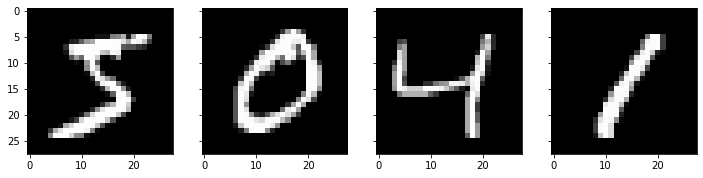

In [7]:
fig, axes = plt.subplots(1,4, figsize=(12,6), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    ax.imshow(mnist_train.data[i], cmap='gray')

### Define the training procedure

We should first make sure that our network is also on our detected device. In case you do not send your model or your data to the same device you will run into errors. 

Next, we should determine for how long, that is how many 'epochs', we want to train our model.

In [8]:
# first, we should make sure the network is on the correct device:
model.to(DEVICE)

# define the number of epochs (that is training iterations) you want your model to go through
# let's say we want this to be 10 epochs
n_epochs = 10

Now we should make use of some cool PyTorch functionallity: DataLoaders!

ToDo: describe

In [9]:
# create the dataloaders
dl_train = DataLoader(mnist_train, batch_size=256, shuffle=True, generator=g)
dl_test = DataLoader(mnist_test, batch_size=256, shuffle=True, generator=g)

In [10]:
# start training the network
train_loss = np.zeros(n_epochs)
test_loss = np.zeros_like(train_loss)
train_acc = np.zeros_like(train_loss)
test_acc = np.zeros_like(train_loss)
for epoch in range(0,n_epochs):

    # make sure the network is in training mode
    if not model.training:
        model.train()

    # calling the model.fit() function will execute the 'standard_train' function as defined above.
    train_loss[epoch], train_stats = model.fit(dl_train, lr=.001, device=DEVICE)
    train_acc[epoch] = compute_accuracy(train_stats[:, -1], train_stats[:, -2])

    # for validating or testing set the network into evaluation mode such that layers like dropout are not active
    model.eval()
    with torch.no_grad():
        test_loss[epoch], test_stats = model.fit(dl_test, device=DEVICE)
        test_acc[epoch] = compute_accuracy(test_stats[:, -1], test_stats[:, -2])

    print('epoch=%03d, train_loss=%1.3f, train_acc=%1.3f, test_loss=%1.3f, test_acc=%1.3f' % 
         (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

epoch=000, train_loss=0.955, train_acc=0.689, test_loss=0.330, test_acc=0.908
epoch=001, train_loss=0.424, train_acc=0.876, test_loss=0.222, test_acc=0.933
epoch=002, train_loss=0.339, train_acc=0.905, test_loss=0.189, test_acc=0.944
epoch=003, train_loss=0.284, train_acc=0.920, test_loss=0.158, test_acc=0.953
epoch=004, train_loss=0.254, train_acc=0.928, test_loss=0.146, test_acc=0.958
epoch=005, train_loss=0.231, train_acc=0.935, test_loss=0.136, test_acc=0.961
epoch=006, train_loss=0.218, train_acc=0.939, test_loss=0.129, test_acc=0.964
epoch=007, train_loss=0.210, train_acc=0.941, test_loss=0.121, test_acc=0.967
epoch=008, train_loss=0.201, train_acc=0.944, test_loss=0.114, test_acc=0.967
epoch=009, train_loss=0.185, train_acc=0.948, test_loss=0.115, test_acc=0.966


That was not so bad was it? Quite simple in fact, I hope. <br>
Please keep in mind that we try to incorporate the epoch loop into the model.fit() function as well. <br>For now, we unfortunately encounter some memory leaks that we first need to solve.

### Check model performance

Let's look if our network really learned something. For that we will plot some loss and accuracy scores as a function of the epoch as well as a confusion matrix for the test data. 

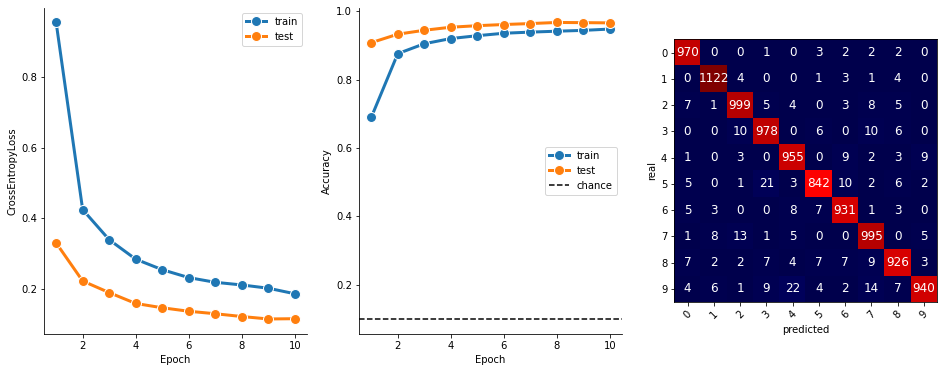

In [11]:
from _utils.plots import confusion_matrix

fig, axes = plt.subplots(1,3,figsize=(16,6))
axes[0].plot(range(1,n_epochs+1), train_loss, range(1,n_epochs+1), test_loss, linewidth=3, marker="o", markersize=10, markeredgecolor="white")
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('CrossEntropyLoss'), axes[0].spines['top'].set_visible(False), axes[0].spines['right'].set_visible(False);
axes[0].legend(("train", "test"));

axes[1].plot(range(1,n_epochs+1), train_acc, range(1,n_epochs+1), test_acc, linewidth=3, marker="o", markersize=10, markeredgecolor="white")
axes[1].axhline(.1, color='black', linestyle='--')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy'), axes[1].spines['top'].set_visible(False), axes[1].spines['right'].set_visible(False);
axes[1].legend(("train", "test", "chance"));

conf_mat = confusion_matrix(test_stats[:,-2], test_stats[:,-1], range(0,10), ax=axes[2])

This looks great! The line plots clearly indicate a downard trend in the loss curve (left) and an upward trend in the accuracy curve, respectively. Further, we can see that the test loss is lower than in the train. This is somewhat interesting as usually the training set performs better than the test or validation data. It is important to note that the loss and accuracy scores are averages for a given epoch. The training set is about 6 times larger than the test set in the case of MNIST. This is only one explanation of why we get curves like these.

Now, let me show you how easy it is to switch to another type of neural network: a convolutional neural network (CNN) model

## Using a CCN

Changing to a CNN with the toolbox is quite simple. Instead of the SimpleLinearModel we now use the Simple2dCnnClassifier. <br>
As the name suggest we are now working with data that is 2-dimensional. Luckily for us the MNIST images are just that. We also know that the MNIST images have 28-by-28 pixels. Thus our input_dims for the model are now [28, 28]. The number of classes remains at 10.
<br>
We also again can use the 'summary' function to better understand how the model is configured. Please NOTE: images usually have color channels, thus the input of our images needs to be (batch, channels, pixeldim1, pixeldim2)

In [12]:
# we actually do exactly the same as for the linear model. 
model = Simple2dCnnClassifier(input_dims=[28, 28], n_classes=10)
print(summary(model, (1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Simple2dCnnClassifier                    [1, 10]                   --
├─ReLU: 1-1                              --                        --
├─Dropout: 1-5                           [1, 256]                  --
├─Sequential: 1-3                        --                        --
│    └─Sequential: 2-1                   [1, 8, 14, 14]            --
│    │    └─Conv2d: 3-1                  [1, 8, 28, 28]            208
│    │    └─ReLU: 3-2                    [1, 8, 28, 28]            --
│    │    └─MaxPool2d: 3-3               [1, 8, 14, 14]            --
│    └─Sequential: 2-2                   [1, 16, 7, 7]             --
│    │    └─Conv2d: 3-4                  [1, 16, 14, 14]           3,216
│    │    └─ReLU: 3-5                    [1, 16, 14, 14]           --
│    │    └─MaxPool2d: 3-6               [1, 16, 7, 7]             --
│    └─Sequential: 2-3                   [1, 32, 3, 3]             --
│    │    └

Alrighty. Make sure you send the model to the device and set the number of epochs you want to use for training. <br>
We can keep the dataloaders as they are.

In [13]:
# first, we should make sure the network is on the correct device:
model.to(DEVICE)

# define the number of epochs (that is training iterations) you want your model to go through
# let's say we want this to be 10 epochs
n_epochs = 10

Ok! Time to train your first 2-D CNN! <br>
Notice that the code below essentially is the same as it is for the linear model. The only thing that changed is some variable names such that we can compare them. But isn't that great? If we find a nice way we turn the below code into a function and simply supply a model to it and it runs. No matter the network. <br>
What is important to note here is that we also changed the learning rate from .001 to .01. Interesting effects can happen if one decreases or increases the learning rate. It is quit common however, that for deeper CNNs larger learning rates work better. 
Finding the best value is covered in a different section, however. 

In [14]:
# start training the network
cnn_train_loss = np.zeros(n_epochs)
cnn_test_loss = np.zeros_like(train_loss)
cnn_train_acc = np.zeros_like(train_loss)
cnn_test_acc = np.zeros_like(train_loss)
for epoch in range(0,n_epochs):

    # make sure the network is in training mode
    if not model.training:
        model.train()

    # calling the model.fit() function will execute the 'standard_train' function as defined above.
    cnn_train_loss[epoch], cnn_train_stats = model.fit(dl_train, lr=.01, device=DEVICE)
    cnn_train_acc[epoch] = compute_accuracy(cnn_train_stats[:, -1], cnn_train_stats[:, -2])

    # for validating or testing set the network into evaluation mode such that layers like dropout are not active
    model.eval()
    with torch.no_grad():
        cnn_test_loss[epoch], cnn_test_stats = model.fit(dl_test, device=DEVICE)
        cnn_test_acc[epoch] = compute_accuracy(cnn_test_stats[:, -1], cnn_test_stats[:, -2])

    print('epoch=%03d, train_loss=%1.3f, train_acc=%1.3f, test_loss=%1.3f, test_acc=%1.3f' % 
         (epoch, cnn_train_loss[epoch], cnn_train_acc[epoch], cnn_test_loss[epoch], cnn_test_acc[epoch]))

epoch=000, train_loss=0.530, train_acc=0.824, test_loss=0.098, test_acc=0.968
epoch=001, train_loss=0.190, train_acc=0.947, test_loss=0.094, test_acc=0.972
epoch=002, train_loss=0.175, train_acc=0.953, test_loss=0.068, test_acc=0.980
epoch=003, train_loss=0.167, train_acc=0.956, test_loss=0.080, test_acc=0.977
epoch=004, train_loss=0.165, train_acc=0.957, test_loss=0.069, test_acc=0.981
epoch=005, train_loss=0.155, train_acc=0.961, test_loss=0.065, test_acc=0.980
epoch=006, train_loss=0.159, train_acc=0.961, test_loss=0.073, test_acc=0.981
epoch=007, train_loss=0.174, train_acc=0.956, test_loss=0.089, test_acc=0.975
epoch=008, train_loss=0.170, train_acc=0.957, test_loss=0.074, test_acc=0.979
epoch=009, train_loss=0.172, train_acc=0.957, test_loss=0.087, test_acc=0.976


Very nice. Let us see if the CNN performed better than the linear model!

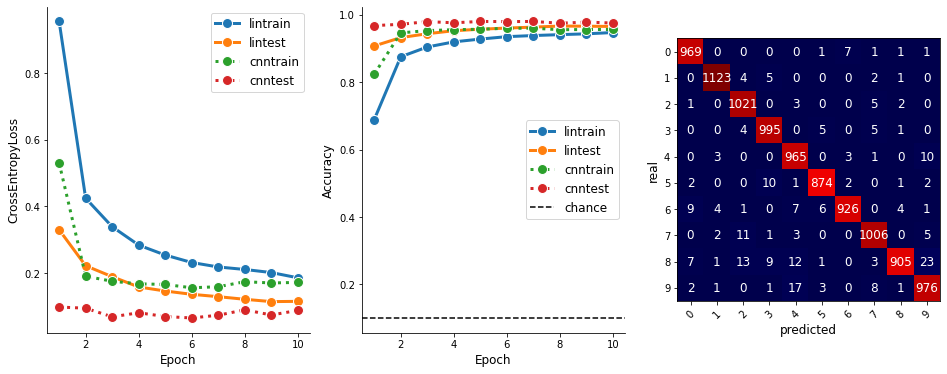

In [15]:
from _utils.plots import confusion_matrix

fig, axes = plt.subplots(1,3,figsize=(16,6))
axes[0].plot(range(1,n_epochs+1), train_loss, 
             range(1,n_epochs+1), test_loss, linewidth=3, marker="o", markersize=10, markeredgecolor="white")
axes[0].plot(range(1,n_epochs+1), cnn_train_loss,
             range(1,n_epochs+1), cnn_test_loss, linewidth=3, linestyle=":", marker="o", markersize=10, markeredgecolor="white")
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('CrossEntropyLoss'), axes[0].spines['top'].set_visible(False), axes[0].spines['right'].set_visible(False);
axes[0].legend(("lintrain", "lintest", "cnntrain", "cnntest"));

axes[1].plot(range(1,n_epochs+1), train_acc, 
             range(1,n_epochs+1), test_acc, linewidth=3, marker="o", markersize=10, markeredgecolor="white")
axes[1].plot(range(1,n_epochs+1), cnn_train_acc,
             range(1,n_epochs+1), cnn_test_acc, linewidth=3, linestyle=":", marker="o", markersize=10, markeredgecolor="white")
axes[1].axhline(.1, color='black', linestyle='--')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy'), axes[1].spines['top'].set_visible(False), axes[1].spines['right'].set_visible(False);
axes[1].legend(("lintrain", "lintest", "cnntrain", "cnntest", "chance"));

conf_mat = confusion_matrix(cnn_test_stats[:,-2], cnn_test_stats[:,-1], range(0,10), ax=axes[2])

## Deprecated for now

In [ ]:
# define the network type you want to train
"""use_model_type = 'lin' # 'lin' or 'cnn'  
classes = np.unique(mnist_train.targets)"""

In [ ]:
"""sfk = StratifiedKFold(n_splits=2)
n_epochs = 3

for fold, (train_idx, test_idx) in enumerate(sfk.split(mnist_train.data, mnist_train.targets)):
    
    # set the name of the run
    run_name = "mnist-%s-fold%03d" % (use_model_type, fold+1)   
    print(f'Running: {run_name}')
    
    # initialize the network for each fold
    if use_model_type == 'lin':
        model = SimpleLinearModel(28**2, len(classes), train_fn=standard_train).to(DEVICE)
    if use_model_type == 'cnn':
        model = Simple2dCnnClassifier([28,28], len(classes), train_fn=standard_train).to(DEVICE)
            
    # create the dataloaders for the current fold
    dl_train = DataLoader(Subset(mnist_train, train_idx), batch_size=256, shuffle=True, generator=g)
    dl_valid = DataLoader(Subset(mnist_train, test_idx), batch_size=256, shuffle=True, generator=g)
    
    # start training the network
    for epoch in range(1,n_epochs+1):
        
        # make sure the network is in training mode
        if not model.training:
            model.train()
        
        train_loss, train_stats = model.fit(dl_train, lr=.001, device=DEVICE)
        train_acc = compute_accuracy(train_stats[:, -1], train_stats[:, -2])
        
        # for validation set the network into evaluation mode such that layers like dropout are not active
        model.eval()
        with torch.no_grad():
            valid_loss, valid_stats = model.fit(dl_valid, device=DEVICE)
            valid_acc = compute_accuracy(valid_stats[:, -1], valid_stats[:, -2])
        
        print(f'epoch={epoch}, train_loss={train_loss}, train_acc={train_acc}, valid_loss={valid_loss}, valid_acc={valid_acc}')
"""